In [35]:
from skimage.io import imread
from skimage.io import imshow
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.sparse import coo_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import seaborn as sn
from sklearn import svm
from sklearn.model_selection import GridSearchCV

In [36]:
happy_images = []
for file in os.listdir('happy/'):
    im = imread(os.path.join('happy/', file),True)
    happy_images.append(np.reshape(im,im.shape[0]*im.shape[1]))

surprise_images = []
for file in os.listdir('surprise/'):
    im = imread(os.path.join('surprise/', file),True)
    surprise_images.append(np.reshape(im,im.shape[0]*im.shape[1]))
        
neutral_images = []
for file in os.listdir('neutral/'):
    im = imread(os.path.join('neutral/', file),True)
    neutral_images.append(np.reshape(im,im.shape[0]*im.shape[1]))
        
disgust_images = []
for file in os.listdir('disgust/'):
    im = imread(os.path.join('disgust/', file),True)
    disgust_images.append(np.reshape(im,im.shape[0]*im.shape[1]))
        
np.random.shuffle(neutral_images)
neutral_train = neutral_images[0:120]
neutral_test = neutral_images[120:]

np.random.shuffle(surprise_images)
surprise_train = surprise_images[0:60]
surprise_test = surprise_images[60:]

np.random.shuffle(happy_images)
happy_train = happy_images[0:60]
happy_test = happy_images[60:]

np.random.shuffle(disgust_images)
disgust_train = disgust_images[0:30]
disgust_test = disgust_images[30:]

train = neutral_train + surprise_train + happy_train + disgust_train
test = neutral_test + surprise_test + happy_test + disgust_test
X_train = np.array(train)
X_test = np.array(test)

y_train = np.concatenate((np.zeros(120),np.ones(60),2*np.ones(60),3*np.ones(30)))
y_test = np.concatenate((np.zeros(70),np.ones(28),2*np.ones(25),3*np.ones(17)))

In [37]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.transform(X_test)
print(X_train_scaler.shape)
print(X_test_scaler.shape)

(270, 180000)
(140, 180000)


In [38]:
pca = PCA(n_components = 250)
pca.fit(X_train_scaler)
pca_train = pca.transform(X_train_scaler)
pca_test = pca.transform(X_test_scaler)

print(pca_train.shape)
print(pca_test.shape)

(270, 250)
(140, 250)


In [39]:
kf = KFold(n_splits=5)
accuracies = []
x = []
for i in range(-8,3):
    clf = LinearSVC(C = 10**i, max_iter= 10000)
    temp = []
    for t, v in kf.split(pca_train):
        X_t, X_valid = pca_train[t], pca_train[v]
        y_t, y_valid = y_train[t], y_train[v]
        clf.fit(X_t,y_t)
        y_predict = clf.predict(X_valid)
        temp.append(f1_score(y_valid, y_predict, average= 'micro'))

    accuracies.append(np.mean(temp))
    x.append(10**i)
    print(f'C = {10**i} : Accuracy = {np.mean(temp)}')
    

C = 1e-08 : Accuracy = 0.47777777777777775
C = 1e-07 : Accuracy = 0.5444444444444445
C = 1e-06 : Accuracy = 0.6666666666666666
C = 1e-05 : Accuracy = 0.7
C = 0.0001 : Accuracy = 0.6370370370370371
C = 0.001 : Accuracy = 0.6074074074074074
C = 0.01 : Accuracy = 0.6111111111111112
C = 0.1 : Accuracy = 0.6148148148148148
C = 1 : Accuracy = 0.6148148148148148
C = 10 : Accuracy = 0.6148148148148148
C = 100 : Accuracy = 0.6148148148148148


best C:  1e-05
best F1_score:  0.7


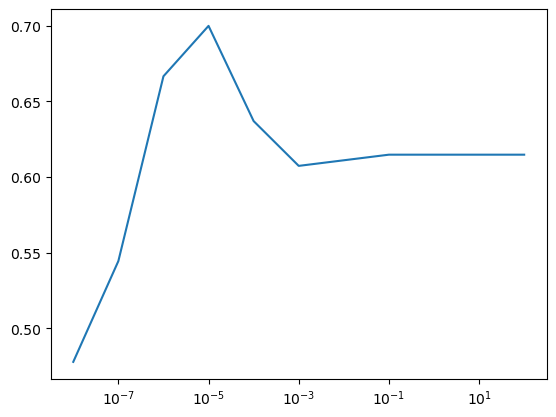

In [40]:
best_C = x[np.argmax(accuracies)]
print('best C: ', best_C)
print('best F1_score: ', max(accuracies))

plt.plot(x, accuracies)
plt.xscale('log')
plt.show()

Score = 0.8571428571428571
Score = 0.8571428571428571
              precision    recall  f1-score   support

         0.0       0.98      0.77      0.86        70
         1.0       0.87      0.96      0.92        28
         2.0       0.83      0.96      0.89        25
         3.0       0.60      0.88      0.71        17

    accuracy                           0.86       140
   macro avg       0.82      0.89      0.85       140
weighted avg       0.89      0.86      0.86       140



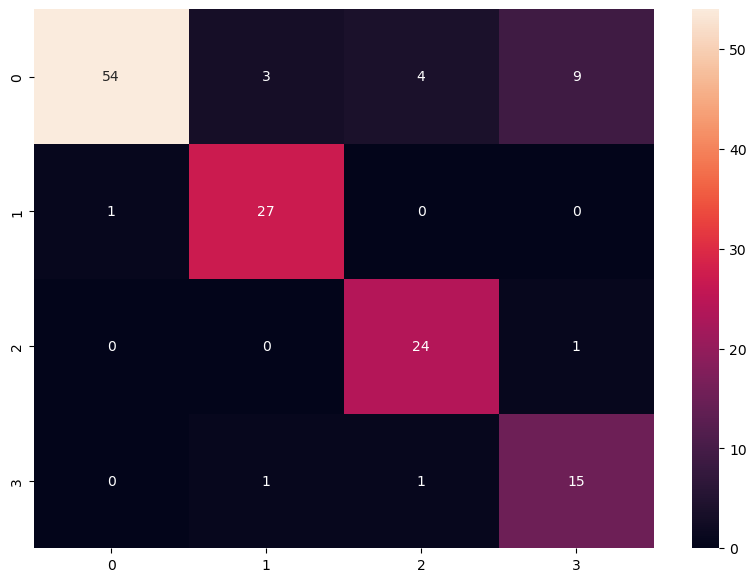

In [41]:
clf = LinearSVC(C = best_C, max_iter=10000)
clf.fit(pca_train,y_train)
y_pred = clf.predict(pca_test)

cm = confusion_matrix(y_test,y_pred)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)

print(f"Score = {clf.score(pca_test,y_test)}")
print(f"Score = {f1_score(y_test,y_pred, average= 'micro')}")
print(classification_report(y_test, y_pred))

Best parameters : {'C': 100, 'gamma': 1e-07}
Score = 0.8642857142857143
              precision    recall  f1-score   support

         0.0       0.83      0.93      0.88        70
         1.0       0.92      0.82      0.87        28
         2.0       0.91      0.84      0.87        25
         3.0       0.86      0.71      0.77        17

    accuracy                           0.86       140
   macro avg       0.88      0.82      0.85       140
weighted avg       0.87      0.86      0.86       140



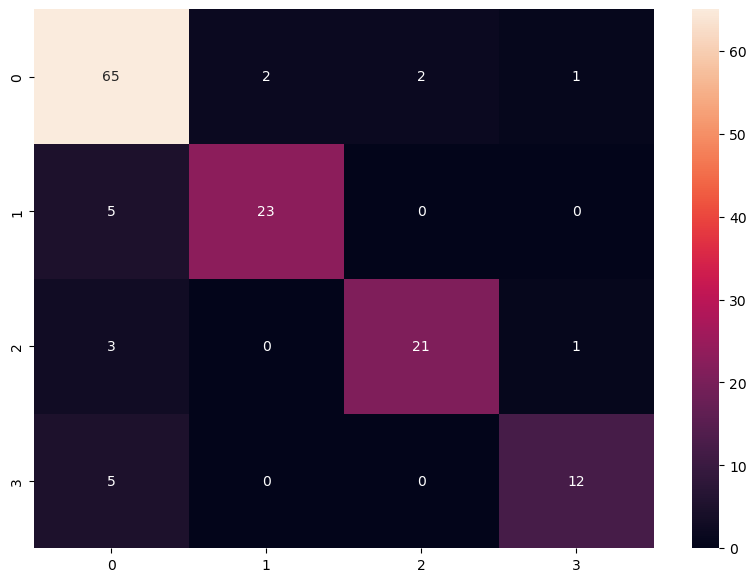

In [42]:
parameters = {'gamma' : [1/(150*pca_train.var()), 0.0000001, 0.000001, 0.00001],   'C':[0.01, 0.1, 1, 10, 100]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(pca_train,y_train)

y_pred = clf.predict(pca_test)
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)

print('Best parameters :', clf.best_params_)

print(f"Score = {clf.score(pca_test,y_test)}")

print(classification_report(y_test, y_pred))